In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#dont run
import os
generated_folder="/content/drive/MyDrive/Images/Generated"
original_folder="/content/drive/MyDrive/Images/Original"
output_base = '/content/drive/MyDrive/projectImages/dataset_split'
train_generated = os.path.join(output_base, 'train/generated')
train_original = os.path.join(output_base, 'train/original')
test_generated = os.path.join(output_base, 'test/generated')
test_original = os.path.join(output_base, 'test/original')

for path in [train_generated, train_original, test_generated, test_original]:
    os.makedirs(path, exist_ok=True)

In [ ]:
#dont run    List all files
import shutil
from sklearn.model_selection import train_test_split
generated_files = [f for f in os.listdir(generated_folder) if os.path.isfile(os.path.join(generated_folder, f))]
original_files = [f for f in os.listdir(original_folder) if os.path.isfile(os.path.join(original_folder, f))]

train_files, test_files = train_test_split(generated_files, test_size=0.1, random_state=42)
trainoriginal_files, testoriginal_files = train_test_split(original_files, test_size=0.1, random_state=42)
def copy_files(file_list, src_folder, dest_folder):
    for file in file_list:
        src_path = os.path.join(src_folder, file)
        dest_path = os.path.join(dest_folder, file)
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)
        else:
            print(f"Warning: {file} not found in {src_folder}")


# Corrected copy calls
copy_files(train_files, generated_folder, train_generated)
copy_files(test_files, generated_folder, test_generated)

copy_files(trainoriginal_files, original_folder, train_original)  # fixed
copy_files(testoriginal_files, original_folder, test_original)    # fixed

print(f"Done! {len(train_files)} for training, {len(test_files)} for testing.")

Done! 2044 for training, 228 for testing.


In [ ]:
#dont run
# Define the folders
train_original_folder = "/content/drive/MyDrive/projectImages/dataset_split/train/original"
train_generated_folder = "/content/drive/MyDrive/projectImages/dataset_split/train/generated"
test_original_folder = "/content/drive/MyDrive/projectImages/dataset_split/test/original"
test_generated_folder = "/content/drive/MyDrive/projectImages/dataset_split/test/generated"

# Define valid image extensions
image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')

# Count images in a folder
def count_images(folder):
    return sum(1 for file in os.listdir(folder) if file.lower().endswith(image_extensions))

# Get the counts
train_original_count = count_images(train_original_folder)
train_generated_count = count_images(train_generated_folder)
test_original_count = count_images(test_original_folder)
test_generated_count = count_images(test_generated_folder)

# Print the counts
print(f"Train - Original: {train_original_count} | Generated: {train_generated_count}")
print(f"Test  - Original: {test_original_count} | Generated: {test_generated_count}")


Train - Original: 2034 | Generated: 2044
Test  - Original: 227 | Generated: 228


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models, optimizers, callbacks
output_base = '/content/drive/MyDrive/Filtered Fashion images/projectImages/dataset_split'
train_dir = os.path.join(output_base, 'train')
test_dir  = os.path.join(output_base, 'test')
IMG_SIZE = (224, 224)       #default input size is 224x224
BATCH_SIZE = 32
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # <-- from VGG16 now
    validation_split=0.1,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=(0.8, 1.2),  # mimic lighting changes
    zoom_range=0.1,
    fill_mode='nearest'

)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=SEED
)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=SEED
)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("Class indices:", train_generator.class_indices)


Found 3671 images belonging to 2 classes.
Found 407 images belonging to 2 classes.
Found 455 images belonging to 2 classes.
Class indices: {'generated': 0, 'original': 1}


In [ ]:
#build vgg16 model

class GaussianNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, stddev=0.1):
        super().__init__()
        self.noise = tf.keras.layers.GaussianNoise(stddev)

    def call(self, inputs, training=None):
        return self.noise(inputs, training=training)

from tensorflow.keras.regularizers import l2
base_model = VGG16(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False
# Add classification head
inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=False)
x = GaussianNoiseLayer(0.1)(x)  # noise after feature maps
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu',kernel_regularizer=l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs, outputs)
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc'),
             F1Score(name='f1_score')],
)

In [ ]:
# 4. Callbacks
checkpoint_path = '/content/drive/MyDrive/vgg16_finetune/checkpoint.h5'
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
checkpoint_cb = callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)
earlystop_cb = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history = model.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint_cb, earlystop_cb]
)

# And after training:
loss, acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test accuracy: {acc:.3f}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.6276 - auc: 0.6756 - f1_score: 0.6418 - loss: 2.7115 - precision: 0.6202 - recall: 0.6651
Epoch 1: val_auc improved from -inf to 0.94769, saving model to /content/drive/MyDrive/vgg16_finetune/checkpoint.h5


419/419 ━━━━━━━━━━━━━━━━━━━━ 334s 749ms/step - accuracy: 0.6278 - auc: 0.6759 - f1_score: 0.6420 - loss: 2.7110 - precision: 0.6203 - recall: 0.6653 - val_accuracy: 0.8845 - val_auc: 0.9477 - val_f1_score: 0.8867 - val_loss: 2.0359 - val_precision: 0.8684 - val_recall: 0.9058
Epoch 2/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.8256 - auc: 0.9059 - f1_score: 0.8301 - loss: 2.0239 - precision: 0.8136 - recall: 0.8473
Epoch 2: val_auc improved from 0.94769 to 0.96694, saving model to /content/drive/MyDrive/vgg16_finetune/checkpoint.h5


419/419 ━━━━━━━━━━━━━━━━━━━━ 346s 701ms/step - accuracy: 0.8256 - auc: 0.9059 - f1_score: 0.8301 - loss: 2.0237 - precision: 0.8136 - recall: 0.8473 - val_accuracy: 0.9060 - val_auc: 0.9669 - val_f1_score: 0.9067 - val_loss: 1.6633 - val_precision: 0.8983 - val_recall: 0.9152
Epoch 3/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.8618 - auc: 0.9379 - f1_score: 0.8629 - loss: 1.6613 - precision: 0.8575 - recall: 0.8686
Epoch 3: val_auc improved from 0.96694 to 0.97114, saving model to /content/drive/MyDrive/vgg16_finetune/checkpoint.h5


419/419 ━━━━━━━━━━━━━━━━━━━━ 321s 700ms/step - accuracy: 0.8619 - auc: 0.9379 - f1_score: 0.8629 - loss: 1.6611 - precision: 0.8575 - recall: 0.8686 - val_accuracy: 0.9187 - val_auc: 0.9711 - val_f1_score: 0.9183 - val_loss: 1.3988 - val_precision: 0.9214 - val_recall: 0.9152
Epoch 4/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.8780 - auc: 0.9507 - f1_score: 0.8797 - loss: 1.3994 - precision: 0.8705 - recall: 0.8892
Epoch 4: val_auc improved from 0.97114 to 0.97284, saving model to /content/drive/MyDrive/vgg16_finetune/checkpoint.h5


419/419 ━━━━━━━━━━━━━━━━━━━━ 323s 702ms/step - accuracy: 0.8780 - auc: 0.9507 - f1_score: 0.8797 - loss: 1.3993 - precision: 0.8705 - recall: 0.8892 - val_accuracy: 0.9161 - val_auc: 0.9728 - val_f1_score: 0.9154 - val_loss: 1.1981 - val_precision: 0.9210 - val_recall: 0.9098
Epoch 5/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.8905 - auc: 0.9589 - f1_score: 0.8911 - loss: 1.1959 - precision: 0.8826 - recall: 0.9000
Epoch 5: val_auc did not improve from 0.97284
419/419 ━━━━━━━━━━━━━━━━━━━━ 323s 704ms/step - accuracy: 0.8905 - auc: 0.9589 - f1_score: 0.8911 - loss: 1.1958 - precision: 0.8826 - recall: 0.9000 - val_accuracy: 0.9174 - val_auc: 0.9718 - val_f1_score: 0.9167 - val_loss: 1.0474 - val_precision: 0.9223 - val_recall: 0.9112
Epoch 6/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.9010 - auc: 0.9656 - f1_score: 0.9012 - loss: 1.0338 - precision: 0.8960 - recall: 0.9065
Epoch 6: val_auc improved from 0.97284 to 0.97323, saving model to /content/drive/My

419/419 ━━━━━━━━━━━━━━━━━━━━ 291s 695ms/step - accuracy: 0.9009 - auc: 0.9656 - f1_score: 0.9012 - loss: 1.0337 - precision: 0.8960 - recall: 0.9065 - val_accuracy: 0.9275 - val_auc: 0.9732 - val_f1_score: 0.9267 - val_loss: 0.9129 - val_precision: 0.9343 - val_recall: 0.9192
Epoch 7/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.9075 - auc: 0.9687 - f1_score: 0.9098 - loss: 0.9080 - precision: 0.9013 - recall: 0.9185
Epoch 7: val_auc improved from 0.97323 to 0.97817, saving model to /content/drive/MyDrive/vgg16_finetune/checkpoint.h5


419/419 ━━━━━━━━━━━━━━━━━━━━ 292s 696ms/step - accuracy: 0.9075 - auc: 0.9687 - f1_score: 0.9098 - loss: 0.9079 - precision: 0.9013 - recall: 0.9185 - val_accuracy: 0.9161 - val_auc: 0.9782 - val_f1_score: 0.9159 - val_loss: 0.8003 - val_precision: 0.9153 - val_recall: 0.9166
Epoch 8/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.9133 - auc: 0.9702 - f1_score: 0.9133 - loss: 0.8072 - precision: 0.9085 - recall: 0.9181
Epoch 8: val_auc improved from 0.97817 to 0.98151, saving model to /content/drive/MyDrive/vgg16_finetune/checkpoint.h5


419/419 ━━━━━━━━━━━━━━━━━━━━ 321s 694ms/step - accuracy: 0.9133 - auc: 0.9702 - f1_score: 0.9133 - loss: 0.8071 - precision: 0.9085 - recall: 0.9181 - val_accuracy: 0.9302 - val_auc: 0.9815 - val_f1_score: 0.9292 - val_loss: 0.7119 - val_precision: 0.9407 - val_recall: 0.9179
Epoch 9/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.9155 - auc: 0.9738 - f1_score: 0.9152 - loss: 0.7218 - precision: 0.9147 - recall: 0.9158
Epoch 9: val_auc did not improve from 0.98151
419/419 ━━━━━━━━━━━━━━━━━━━━ 342s 743ms/step - accuracy: 0.9155 - auc: 0.9738 - f1_score: 0.9152 - loss: 0.7218 - precision: 0.9147 - recall: 0.9158 - val_accuracy: 0.9396 - val_auc: 0.9815 - val_f1_score: 0.9382 - val_loss: 0.6474 - val_precision: 0.9579 - val_recall: 0.9192
Epoch 10/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.9221 - auc: 0.9777 - f1_score: 0.9229 - loss: 0.6496 - precision: 0.9217 - recall: 0.9242
Epoch 10: val_auc improved from 0.98151 to 0.98158, saving model to /content/drive/

419/419 ━━━━━━━━━━━━━━━━━━━━ 303s 721ms/step - accuracy: 0.9221 - auc: 0.9777 - f1_score: 0.9229 - loss: 0.6496 - precision: 0.9217 - recall: 0.9242 - val_accuracy: 0.9342 - val_auc: 0.9816 - val_f1_score: 0.9332 - val_loss: 0.5906 - val_precision: 0.9461 - val_recall: 0.9206
Epoch 11/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.9220 - auc: 0.9774 - f1_score: 0.9222 - loss: 0.5984 - precision: 0.9203 - recall: 0.9242
Epoch 11: val_auc improved from 0.98158 to 0.98488, saving model to /content/drive/MyDrive/vgg16_finetune/checkpoint.h5


419/419 ━━━━━━━━━━━━━━━━━━━━ 300s 715ms/step - accuracy: 0.9221 - auc: 0.9774 - f1_score: 0.9222 - loss: 0.5984 - precision: 0.9203 - recall: 0.9242 - val_accuracy: 0.9436 - val_auc: 0.9849 - val_f1_score: 0.9421 - val_loss: 0.5425 - val_precision: 0.9661 - val_recall: 0.9192
Epoch 12/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.9292 - auc: 0.9806 - f1_score: 0.9289 - loss: 0.5478 - precision: 0.9269 - recall: 0.9310
Epoch 12: val_auc did not improve from 0.98488
419/419 ━━━━━━━━━━━━━━━━━━━━ 321s 714ms/step - accuracy: 0.9292 - auc: 0.9806 - f1_score: 0.9290 - loss: 0.5477 - precision: 0.9269 - recall: 0.9310 - val_accuracy: 0.9275 - val_auc: 0.9796 - val_f1_score: 0.9264 - val_loss: 0.5172 - val_precision: 0.9379 - val_recall: 0.9152
Epoch 13/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.9374 - auc: 0.9846 - f1_score: 0.9376 - loss: 0.5026 - precision: 0.9342 - recall: 0.9412
Epoch 13: val_auc improved from 0.98488 to 0.98566, saving model to /content/driv

419/419 ━━━━━━━━━━━━━━━━━━━━ 296s 706ms/step - accuracy: 0.9374 - auc: 0.9846 - f1_score: 0.9376 - loss: 0.5026 - precision: 0.9342 - recall: 0.9412 - val_accuracy: 0.9422 - val_auc: 0.9857 - val_f1_score: 0.9413 - val_loss: 0.4715 - val_precision: 0.9544 - val_recall: 0.9287
Epoch 14/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.9400 - auc: 0.9859 - f1_score: 0.9403 - loss: 0.4692 - precision: 0.9441 - recall: 0.9366
Epoch 14: val_auc did not improve from 0.98566
419/419 ━━━━━━━━━━━━━━━━━━━━ 320s 703ms/step - accuracy: 0.9400 - auc: 0.9859 - f1_score: 0.9403 - loss: 0.4692 - precision: 0.9441 - recall: 0.9366 - val_accuracy: 0.9234 - val_auc: 0.9756 - val_f1_score: 0.9205 - val_loss: 0.4770 - val_precision: 0.9551 - val_recall: 0.8883
Epoch 15/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.9372 - auc: 0.9839 - f1_score: 0.9372 - loss: 0.4508 - precision: 0.9343 - recall: 0.9401
Epoch 15: val_auc did not improve from 0.98566
419/419 ━━━━━━━━━━━━━━━━━━━━ 311s 

419/419 ━━━━━━━━━━━━━━━━━━━━ 327s 715ms/step - accuracy: 0.9469 - auc: 0.9885 - f1_score: 0.9470 - loss: 0.3907 - precision: 0.9428 - recall: 0.9513 - val_accuracy: 0.9422 - val_auc: 0.9862 - val_f1_score: 0.9409 - val_loss: 0.3899 - val_precision: 0.9607 - val_recall: 0.9219
Epoch 19/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.9495 - auc: 0.9891 - f1_score: 0.9494 - loss: 0.3783 - precision: 0.9487 - recall: 0.9503
Epoch 19: val_auc did not improve from 0.98622
419/419 ━━━━━━━━━━━━━━━━━━━━ 298s 711ms/step - accuracy: 0.9495 - auc: 0.9891 - f1_score: 0.9494 - loss: 0.3783 - precision: 0.9487 - recall: 0.9503 - val_accuracy: 0.9322 - val_auc: 0.9853 - val_f1_score: 0.9308 - val_loss: 0.3861 - val_precision: 0.9483 - val_recall: 0.9139
Epoch 20/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.9484 - auc: 0.9892 - f1_score: 0.9487 - loss: 0.3679 - precision: 0.9486 - recall: 0.9490
Epoch 20: val_auc did not improve from 0.98622
419/419 ━━━━━━━━━━━━━━━━━━━━ 298s 

'\nloss, acc = model.evaluate(test_generator, steps=len(test_generator))\nprint(f"Test accuracy: {acc:.3f}")'

In [ ]:
results = model.evaluate(
    test_generator,
    steps=len(test_generator),
    verbose=1
)

# See in what order they come back:
print(model.metrics_names)
# e.g. ['loss', 'accuracy', 'precision', 'recall', 'auc', 'f1_score']

loss, accuracy, precision, recall, auc, f1_score = results

print(f"Test → loss: {loss:.4f}")
print(f"       accuracy: {accuracy:.3f}")
print(f"       precision: {precision:.3f}")
print(f"       recall: {recall:.3f}")
print(f"       AUC: {auc:.3f}")
print(f"       F1‑score: {f1_score:.3f}")


52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 426ms/step - accuracy: 0.9944 - auc: 0.5283 - f1_score: 0.5193 - loss: 0.2984 - precision: 0.5164 - recall: 0.5240
['loss', 'compile_metrics']
Test → loss: 0.2976
       accuracy: 0.996
       precision: 0.998
       recall: 0.995
       AUC: 1.000
       F1‑score: 0.996


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 1) Predict probabilities or logits
y_prob = model.predict(test_generator, steps=len(test_generator))
# 2) Convert to binary labels (threshold=0.5 by default)
y_pred = (y_prob > 0.5).astype(int).flatten()

# 3) True labels
y_true = test_generator.classes  # assuming ImageDataGenerator.flow_from_directory

# 4) Classification report & confusion matrix
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 236ms/step
              precision    recall  f1-score   support

   generated       1.00      1.00      1.00       829
    original       1.00      1.00      1.00       827

    accuracy                           1.00      1656
   macro avg       1.00      1.00      1.00      1656
weighted avg       1.00      1.00      1.00      1656

Confusion Matrix:
 [[827   2]
 [  4 823]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 403ms/step


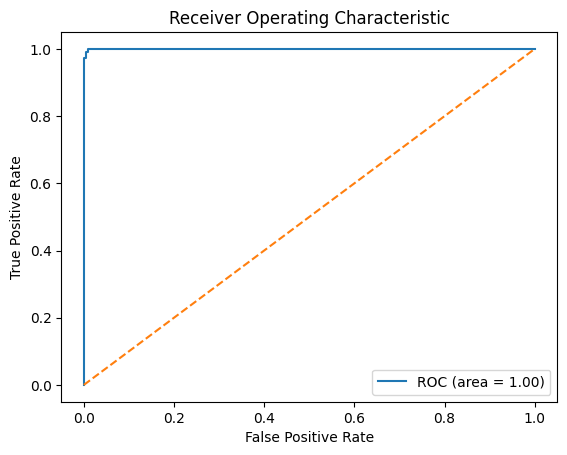

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = model.predict(test_generator, steps=len(test_generator)).ravel()
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC (area = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
